In [82]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import difflib
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from sklearn.linear_model import LogisticRegression as LR

In [111]:
df = pd.read_csv('../datasets/all_merged.csv')
df.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Position.on.Handling.Terrorism.Abroad,Position.on.Russia,Party.Category,Party.Category.1,Incumbency,Female,Democrat,Republican,SinglePayer,firstlast
0,Lizzetta Hill McConnell,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,0,None,None,-30.680000,...,Candidate provides no information,Candidate provides no information,Establishment Democrat,NaN,0,1.0,1,0,NaN,lizetta mcconnell
1,Robert Kennedy Jr.,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,1,None,On the Ballot,-30.680000,...,Candidate provides no information,Candidate provides no information,Establishment Democrat,NaN,0,0.0,1,0,NaN,robert kennedy
2,Audri Scott Williams,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,0,None,None,-33.080002,...,Candidate provides no information,Candidate provides no information,Progressive Democrat,NaN,0,1.0,1,0,"Yes, candidate supports universal healthcare r...",audri williams
3,Tabitha Isner,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,1,None,On the Ballot,-33.080002,...,Candidate provides no information,Candidate provides no information,Progressive Democrat,NaN,0,1.0,1,0,"Yes, candidate supports universal healthcare r...",tabitha isner
4,Adia McClellan Winfrey,AL,U.S. House Alabama District 3,Representative,Regular,6/5/18,0,None,None,-33.660000,...,Candidate provides no information,Candidate provides no information,Other,NaN,0,1.0,1,0,NaN,adia winfrey


## Functions

In [104]:
# function for estimating treatment effect
def estimate_treatment_effect(model, X, Y, Z):
    return np.mean((Z * Y / model.predict_proba(X)[:, 1]) - ((1 - Z) * Y / model.predict_proba(X)[:, 0]))

## Inverse Propensity Weighting: Party Support
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Party Support?'`
- X (confounders): `'Total Other Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [106]:
all_merged.columns

Index(['Candidate', 'State', 'District', 'Office Type', 'Race Type',
       'Race Primary Election Date', 'Primary Status', 'Primary Runoff Status',
       'General Status', 'Partisan Lean', 'Primary %', 'Won Primary', 'Race',
       'Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?',
       'Obama Alum?', 'Party Support?', 'Emily Endorsed?',
       'Gun Sense Candidate?', 'Biden Endorsed?', 'Warren Endorsed?',
       'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?',
       'WFP Endorsed?', 'VoteVets Endorsed?', 'No Labels Support?',
       'total_runners', 'Total Endorsements', 'Endorsed', 'receipts',
       'lw_Candidate', 'matches', 'Candidate.First.Name',
       'Candidate.Last.Name', 'Candidate.State', 'Candidate.District',
       'Candidate.Gender', 'Listed.military.service.', 'Education',
       'Marital.Status', 'Previous.Electoral.Experience',
       'Position.on.Affordable.Care.Act..Oba

In [107]:
all_merged['Listed.military.service.']

0      No, the candidate does not include any informa...
1      Yes, the candidate serves or served in the mil...
2      Yes, the candidate serves or served in the mil...
3      No, the candidate does not include any informa...
4      No, the candidate does not include any informa...
5      No, the candidate does not include any informa...
6      No, the candidate does not include any informa...
7      Yes, the candidate serves or served in the mil...
8      No, the candidate does not include any informa...
9      Yes, the candidate serves or served in the mil...
10     No, the candidate does not include any informa...
11     No, the candidate does not include any informa...
12     No, the candidate does not include any informa...
13     No, the candidate does not include any informa...
14     No, the candidate does not include any informa...
15     No, the candidate does not include any informa...
16     No, the candidate does not include any informa...
17     No, the candidate does n

In [37]:
party = all_merged[all_merged['Party Support?'].notnull() == True][['Won Primary', 'Party Support?', 'Total Endorsements', 'Partisan Lean', 'Race', 'Listed.military.service.', 'LGBTQ?', 'STEM?', 'Elected Official?', 'receipts']].reset_index().drop(columns=['index']).dropna()
party['Total Other Endorsements'] = party['Total Endorsements'] - party['Party Support?']
party = party.drop(columns=['Total Endorsements'])[party['receipts'].notnull()]
party.head()

,Won Primary,Party Support?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements
0,1,1.0,-13.51,0,0,0,0,1,2366991.03,1.0
1,0,0.0,-13.51,0,1,0,0,0,33934.76,1.0
2,0,0.0,-13.51,1,0,0,0,0,34466.05,0.0
3,0,0.0,-13.51,0,0,0,0,0,270092.89,0.0
4,0,0.0,0.62,0,0,0,1,0,68767.16,2.0


In [38]:
# creating our treatment, outcome, and confounder arrays
Z = party['Party Support?'].values
Y = party['Won Primary'].values
X = party.drop(['Party Support?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

estimate_treatment_effect(fit, X, Y, Z)

0.22853389931489862

In [39]:
# the naive estimator does not account for confounders!
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.9014184397163121

### Adding the propensity scores

In [40]:
party['pscore'] = fit.predict_proba(X)[:, 1]
party.head()

,Won Primary,Party Support?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements,pscore
0,1,1.0,-13.51,0,0,0,0,1,2366991.03,1.0,0.634807
1,0,0.0,-13.51,0,1,0,0,0,33934.76,1.0,0.501982
2,0,0.0,-13.51,1,0,0,0,0,34466.05,0.0,0.502013
3,0,0.0,-13.51,0,0,0,0,0,270092.89,0.0,0.515767
4,0,0.0,0.62,0,0,0,1,0,68767.16,2.0,0.504016


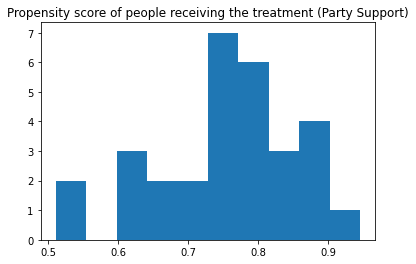

In [41]:
plt.hist(party[party['Party Support?'] == 1]['pscore']);
plt.title("Propensity score of people receiving the treatment (Party Support)")
plt.savefig('party_support_treat.png');

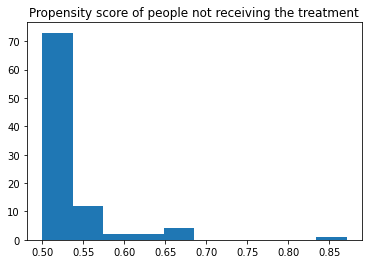

In [42]:
plt.hist(party[party['Party Support?'] == 0]['pscore']);
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('party_support_ctrl.png');

### IPW Estimate

In [43]:
reweighted_treated = (party[party['Party Support?'] == 1]['Won Primary'] / party[party['Party Support?'] == 1]['pscore']).sum()
reweighted_control = (party[party['Party Support?'] == 0]['Won Primary'] / (1 - party[party['Party Support?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(party)
print('IPW estimate:', ipw_estimate)

obs_filt = party[party['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Party Support?'] == 1]['Won Primary'] / obs_filt[obs_filt['Party Support?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Party Support?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Party Support?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.22853389931489862
trimmed IPW estimate: 0.2217985299710571


## Inverse Propensity Weighting: Our Revolution
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Our Revolution Endorsed?'`
- X (confounders): `'Total Other Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [44]:
our_rev = merged[merged['Our Revolution Endorsed?'].notnull() == True][['Won Primary', 'Our Revolution Endorsed?', 'Total Endorsements', 'Partisan Lean', 'Race', 'Veteran?', 'LGBTQ?', 'STEM?', 'Elected Official?', 'receipts']].reset_index().drop(columns=['index']).dropna()
our_rev['Total Other Endorsements'] = our_rev['Total Endorsements'] - our_rev['Our Revolution Endorsed?']
our_rev = our_rev.drop(columns=['Total Endorsements'])[our_rev['receipts'].notnull()]
our_rev.head()

,Won Primary,Our Revolution Endorsed?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements
0,1,1.0,-21.379999,0,0,0,0,0,1097584.95,1.0
1,0,0.0,-21.379999,0,0,0,0,0,17275.00,0.0
2,0,0.0,-21.379999,0,0,0,0,0,290020.57,0.0
3,0,0.0,-21.379999,0,0,0,0,0,68655.53,1.0
4,0,1.0,0.620000,0,0,0,1,0,68767.16,1.0


In [45]:
# creating our treatment, outcome, and confounder arrays
Z = our_rev['Our Revolution Endorsed?'].values
Y = our_rev['Won Primary'].values
X = our_rev.drop(['Our Revolution Endorsed?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

estimate_treatment_effect(fit, X, Y, Z)

0.09643207821222963

Since this is a negative number, the treatment (being endorsed by `Our Revolution`) caused the probability of winning to decrease.

In [46]:
# naive estimator from HW4, not sure if we need for this
# the naive estimator does not account for confounders!
# Interesting... once we control for confounders, we observe the opposite effect (positive to negative)
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.08556231003039513

### Adding the propensity scores

In [47]:
our_rev['pscore'] = fit.predict_proba(X)[:, 1]
our_rev.head()

,Won Primary,Our Revolution Endorsed?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements,pscore
0,1,1.0,-21.379999,0,0,0,0,0,1097584.95,1.0,0.374233
1,0,0.0,-21.379999,0,0,0,0,0,17275.00,0.0,0.497977
2,0,0.0,-21.379999,0,0,0,0,0,290020.57,0.0,0.466091
3,0,0.0,-21.379999,0,0,0,0,0,68655.53,1.0,0.491961
4,0,1.0,0.620000,0,0,0,1,0,68767.16,1.0,0.491948


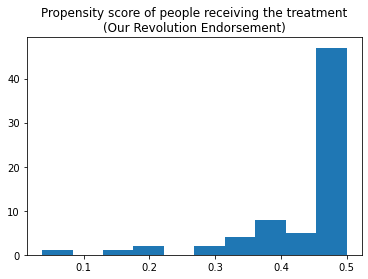

In [48]:
plt.hist(our_rev[our_rev['Our Revolution Endorsed?'] == 1]['pscore'])
plt.title("Propensity score of people receiving the treatment\n(Our Revolution Endorsement)")
plt.savefig('our_rev_treat.png');

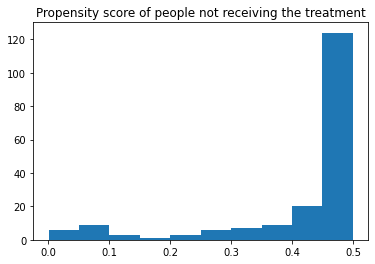

In [49]:
plt.hist(our_rev[our_rev['Our Revolution Endorsed?'] == 0]['pscore'])
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('our_rev_ctrl.png');

### IPW Estimate

In [50]:
reweighted_treated = (our_rev[our_rev['Our Revolution Endorsed?'] == 1]['Won Primary'] / our_rev[our_rev['Our Revolution Endorsed?'] == 1]['pscore']).sum()
reweighted_control = (our_rev[our_rev['Our Revolution Endorsed?'] == 0]['Won Primary'] / (1 - our_rev[our_rev['Our Revolution Endorsed?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(our_rev)
print('IPW estimate:', ipw_estimate)

obs_filt = our_rev[our_rev['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Our Revolution Endorsed?'] == 1]['Won Primary'] / obs_filt[obs_filt['Our Revolution Endorsed?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Our Revolution Endorsed?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Our Revolution Endorsed?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.09643207821222961
trimmed IPW estimate: 0.05568433328834726


## Inverse Propensity Weighting: Emily's List
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Emily Endorsed?'`
- X (confounders): `'Total Other Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [51]:
emily = merged[merged['Emily Endorsed?'].notnull() == True][['Won Primary', 'Emily Endorsed?', 'Total Endorsements', 'Partisan Lean', 'Race', 'Veteran?', 'LGBTQ?', 'STEM?', 'Elected Official?', 'receipts']].reset_index().drop(columns=['index'])
emily['Total Other Endorsements'] = emily['Total Endorsements'] - emily['Emily Endorsed?']
emily = emily.drop(columns=['Total Endorsements'])[emily['receipts'].notnull()]
emily.head()

,Won Primary,Emily Endorsed?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements
0,0,0.0,0.62,0,0,0,1,0,68767.16,2.0
1,1,0.0,0.62,0,0,0,1,0,8441529.09,2.0
2,0,0.0,0.62,0,0,0,0,0,346820.52,0.0
3,0,0.0,0.62,0,1,0,1,0,48734.30,0.0
4,0,0.0,0.62,0,0,0,1,1,840266.61,0.0


In [52]:
# creating our treatment, outcome, and confounder arrays
Z = emily['Emily Endorsed?'].values
Y = emily['Won Primary'].values
X = emily.drop(['Emily Endorsed?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

estimate_treatment_effect(fit, X, Y, Z)

0.20195515235529135

In [53]:
# the naive estimator does not account for confounders!
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.6101842196732707

### Adding the propensity scores

In [54]:
emily['pscore'] = fit.predict_proba(X)[:, 1]
emily.head()

,Won Primary,Emily Endorsed?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements,pscore
0,0,0.0,0.62,0,0,0,1,0,68767.16,2.0,0.499988
1,1,0.0,0.62,0,0,0,1,0,8441529.09,2.0,0.498499
2,0,0.0,0.62,0,0,0,0,0,346820.52,0.0,0.499938
3,0,0.0,0.62,0,1,0,1,0,48734.30,0.0,0.499991
4,0,0.0,0.62,0,0,0,1,1,840266.61,0.0,0.499851


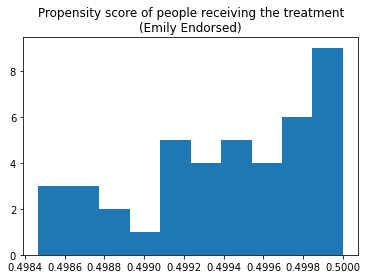

In [55]:
plt.hist(emily[emily['Emily Endorsed?'] == 1]['pscore'])
plt.title("Propensity score of people receiving the treatment\n(Emily Endorsed)")
plt.savefig('emily_treat.png');

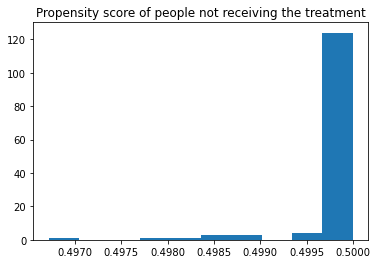

In [56]:
plt.hist(emily[emily['Emily Endorsed?'] == 0]['pscore'])
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('emily_ctrl.png');

### IPW Estimate

In [57]:
reweighted_treated = (emily[emily['Emily Endorsed?'] == 1]['Won Primary'] / emily[emily['Emily Endorsed?'] == 1]['pscore']).sum()
reweighted_control = (emily[emily['Emily Endorsed?'] == 0]['Won Primary'] / (1 - emily[emily['Emily Endorsed?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(emily)
print('IPW estimate:', ipw_estimate)

obs_filt = emily[emily['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Emily Endorsed?'] == 1]['Won Primary'] / obs_filt[obs_filt['Emily Endorsed?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Emily Endorsed?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Emily Endorsed?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.20195515235529135
trimmed IPW estimate: 0.20195515235529135


## Inverse Propensity Weighting: Justice Dems
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Justice Dems Endorsed?'`
- X (confounders): `'Total Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [58]:
jd = merged[merged['Justice Dems Endorsed?'].notnull() == True][['Won Primary', 'Justice Dems Endorsed?', 'Total Endorsements', 'Partisan Lean', 'Race', 'Veteran?', 'LGBTQ?', 'STEM?', 'Elected Official?', 'receipts']].reset_index().drop(columns=['index'])
jd['Total Other Endorsements'] = jd['Total Endorsements'] - jd['Justice Dems Endorsed?']
jd = jd.drop(columns=['Total Endorsements'])[jd['receipts'].notnull()]
jd.head()

,Won Primary,Justice Dems Endorsed?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements
0,1,1.0,-21.379999,0,0,0,0,0,1097584.95,1.0
1,0,0.0,-21.379999,0,0,0,0,0,17275.00,0.0
2,0,0.0,-21.379999,0,0,0,0,0,290020.57,0.0
3,0,0.0,-21.379999,0,0,0,0,0,68655.53,1.0
4,0,1.0,0.620000,0,0,0,1,0,68767.16,1.0


In [59]:
# creating our treatment, outcome, and confounder arrays
Z = jd['Justice Dems Endorsed?'].values
Y = jd['Won Primary'].values
X = jd.drop(['Justice Dems Endorsed?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

estimate_treatment_effect(fit, X, Y, Z)

0.10498301473032351

In [60]:
# the naive estimator does not account for confounders!
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.03787878787878787

### Adding the propensity scores

In [61]:
jd['pscore'] = fit.predict_proba(X)[:, 1]
jd.head()

,Won Primary,Justice Dems Endorsed?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements,pscore
0,1,1.0,-21.379999,0,0,0,0,0,1097584.95,1.0,0.310410
1,0,0.0,-21.379999,0,0,0,0,0,17275.00,0.0,0.496859
2,0,0.0,-21.379999,0,0,0,0,0,290020.57,0.0,0.447466
3,0,0.0,-21.379999,0,0,0,0,0,68655.53,1.0,0.487520
4,0,1.0,0.620000,0,0,0,1,0,68767.16,1.0,0.487500


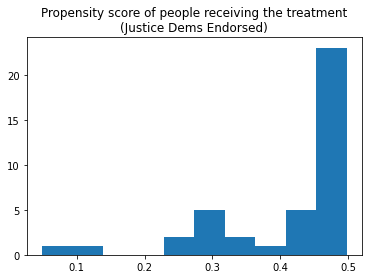

In [62]:
plt.hist(jd[jd['Justice Dems Endorsed?'] == 1]['pscore'])
plt.title("Propensity score of people receiving the treatment\n(Justice Dems Endorsed)")
plt.savefig('justice_dems_treat.png');

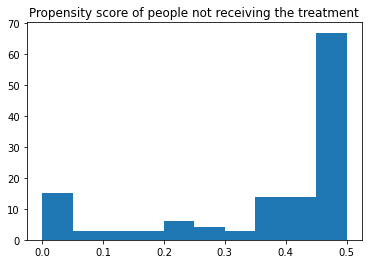

In [63]:
plt.hist(jd[jd['Justice Dems Endorsed?'] == 0]['pscore'])
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('justice_dems_ctrl.png');

### IPW Estimate

In [64]:
reweighted_treated = (jd[jd['Justice Dems Endorsed?'] == 1]['Won Primary'] / jd[jd['Justice Dems Endorsed?'] == 1]['pscore']).sum()
reweighted_control = (jd[jd['Justice Dems Endorsed?'] == 0]['Won Primary'] / (1 - jd[jd['Justice Dems Endorsed?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(jd)
print('IPW estimate:', ipw_estimate)

obs_filt = jd[jd['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Justice Dems Endorsed?'] == 1]['Won Primary'] / obs_filt[obs_filt['Justice Dems Endorsed?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Justice Dems Endorsed?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Justice Dems Endorsed?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.10498301473032351
trimmed IPW estimate: 0.09851099666720017


## Inverse Propensity Weighting: Gun Sense
- Y (outcome): `'Won Primary'`
- Z (treatment): `'Gun Sense Candidate?'`
- X (confounders): `'Total Endorsements'`, `'Partisan Lean'`, `'Race'`, `'Veteran?'`, `'LGBTQ?'`, `'STEM?'`, `'Elected Official?'`, `'receipts'`

In [65]:
gs = merged[merged['Gun Sense Candidate?'].notnull() == True][['Won Primary', 'Gun Sense Candidate?', 'Total Endorsements', 'Partisan Lean', 'Race', 'Veteran?', 'LGBTQ?', 'STEM?', 'Elected Official?', 'receipts']].reset_index().drop(columns=['index'])
gs['Total Other Endorsements'] = gs['Total Endorsements'] - gs['Gun Sense Candidate?']
gs = gs.drop(columns=['Total Endorsements'])[gs['receipts'].notnull()]
gs.head()

,Won Primary,Gun Sense Candidate?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements
0,0,1.0,-33.66,1,0,0,1,0,14535.25,0.0
1,1,1.0,-33.66,0,0,0,0,0,467514.71,0.0
2,1,1.0,-62.48,0,0,0,0,0,70425.87,0.0
3,0,0.0,-62.48,0,1,0,0,0,21088.35,0.0
4,1,1.0,-13.51,0,0,0,0,1,2366991.03,1.0


In [66]:
# creating our treatment, outcome, and confounder arrays
Z = gs['Gun Sense Candidate?'].values
Y = gs['Won Primary'].values
X = gs.drop(['Gun Sense Candidate?', 'Won Primary'], axis=1).to_numpy()

# getting propensity scores through logistic regression
lr = LR(penalty='none', max_iter=200, random_state=0)
fit = lr.fit(X, Z)

estimate_treatment_effect(fit, X, Y, Z)

0.13881062411013584

In [67]:
# the naive estimator does not account for confounders!
np.mean(Y[Z == 1] * Z[Z == 1]) - np.mean(Y[Z == 0] * (1 - Z[Z == 0]))

0.3217761557177616

### Adding the propensity scores


In [68]:
gs['pscore'] = fit.predict_proba(X)[:, 1]
gs.head()

,Won Primary,Gun Sense Candidate?,Partisan Lean,Race,Veteran?,LGBTQ?,STEM?,Elected Official?,receipts,Total Other Endorsements,pscore
0,0,1.0,-33.66,1,0,0,1,0,14535.25,0.0,0.501378
1,1,1.0,-33.66,0,0,0,0,0,467514.71,0.0,0.544193
2,1,1.0,-62.48,0,0,0,0,0,70425.87,0.0,0.506674
3,0,0.0,-62.48,0,1,0,0,0,21088.35,0.0,0.501999
4,1,1.0,-13.51,0,0,0,0,1,2366991.03,1.0,0.710401


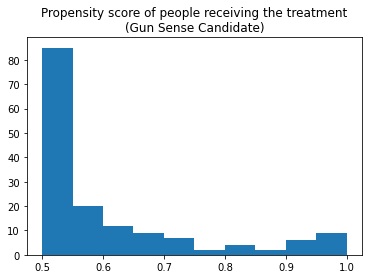

In [69]:
plt.hist(gs[gs['Gun Sense Candidate?'] == 1]['pscore'])
plt.title("Propensity score of people receiving the treatment\n(Gun Sense Candidate)")
plt.savefig('gun_sense_treat.png');

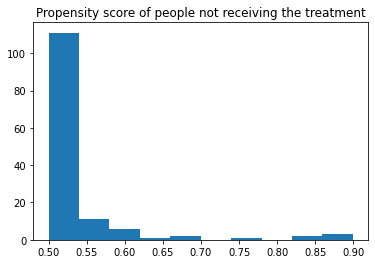

In [70]:
plt.hist(gs[gs['Gun Sense Candidate?'] == 0]['pscore'])
plt.title("Propensity score of people not receiving the treatment")
plt.savefig('gun_sense_ctrl.png');

### IPW Estimate

In [71]:
reweighted_treated = (gs[gs['Gun Sense Candidate?'] == 1]['Won Primary'] / gs[gs['Gun Sense Candidate?'] == 1]['pscore']).sum()
reweighted_control = (gs[gs['Gun Sense Candidate?'] == 0]['Won Primary'] / (1 - gs[gs['Gun Sense Candidate?'] == 0]['pscore'])).sum()
ipw_estimate = (reweighted_treated - reweighted_control) / len(gs)
print('IPW estimate:', ipw_estimate)

obs_filt = gs[gs['pscore'].between(0.1, 0.9)]
reweighted_treated_filt = (obs_filt[obs_filt['Gun Sense Candidate?'] == 1]['Won Primary'] / obs_filt[obs_filt['Gun Sense Candidate?'] == 1]['pscore']).sum()
reweighted_control_filt = (obs_filt[obs_filt['Gun Sense Candidate?'] == 0]['Won Primary'] / (1 - obs_filt[obs_filt['Gun Sense Candidate?'] == 0]['pscore'])).sum()
trimmed_ipw_estimate = (reweighted_treated_filt - reweighted_control_filt) / len(obs_filt)
print('trimmed IPW estimate:', trimmed_ipw_estimate)

IPW estimate: 0.13881062411013584
trimmed IPW estimate: 0.08960197814165571


## Bootstrapping ATE estimates

In [72]:
#TODO: Fill in the missing values
def draw_tau_hat(data=obs, random_state=None):
    """Returns a single bootstrapped estimate of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        random_state: integer to help standardize sampling output 
        for grading and troubleshooting purposes
    Output:
        float, estimated average treatment effect
    """
    sample = data.sample(frac=1, replace=True, random_state=random_state)
    fit_model = fit_OLS_model(sample, 'outcome', ['treat', 'age', 'educ', 'black', 'hisp', 'marr', 'nodegree'])
    estimated_ate = fit_model.params['treat']
    return estimated_ate

def get_bootstrapped_ate(data=obs, n=1000):
    """Returns n bootstrapped estimates of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        n: number of bootstrapped estimates we would like to return
    Output:
        list of estimated average treatment effects
    """
    estimates = []
    for i in np.arange(n):
        estimates.append(draw_tau_hat(data))
    return estimates

NameError: name 'obs' is not defined